# Baseline model
In this notebook we explore our options for a baseline model. We also look at what preprocessing steps are needed.

In [2]:
import pandas as pd
import numpy as np
import os

RANDOM_SEED = 21223

Unzip dataset

In [3]:
from zipfile import ZipFile
dir_path = "../data"
train_path = dir_path + "/asl_train"
test_path = dir_path + "/asl_test"

def unzip_if_not_exists(zip_file_path, extract_to_path):
    # check if the target directory already exists
    if not os.path.exists(extract_to_path):
        # create the directory if it doesn't exist
        os.makedirs(extract_to_path)
        # unzip the contents
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"Successfully unzipped to {extract_to_path}")
    else:
        print(f"The directory {extract_to_path} already exists. Skipped unzipping.")

unzip_if_not_exists(dir_path + "/asl_alphabet_train.zip", train_path)
unzip_if_not_exists(dir_path + "/asl_alphabet_test.zip", test_path)

The directory ../data/asl_train already exists. Skipped unzipping.
The directory ../data/asl_test already exists. Skipped unzipping.


Store all data in a pandas df

In [4]:
train_path += "/asl_alphabet_train/"
test_path += "/asl_alphabet_test/"

# map alphabet to numbers
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "K",
                10: "L",
                11: "M",
                12: "N",
                13: "O",
                14: "P",
                15: "Q",
                16: "R",
                17: "S",
                18: "T",
                19: "U",
                20: "V",
                21: "W",
                22: "X",
                23: "Y",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df

# store all the file names in the dataset
filenames = []
# store the corresponding class for each file
target = []

for category in categories:
    files = os.listdir(train_path + categories[category])
    filenames += files
    target += [category] * len(files)

df = pd.DataFrame({"filename": filenames, "category": target})
df = add_class_name_prefix(df, "filename")

# shuffle the dataframe
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

check it out

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  72000 non-null  object
 1   category  72000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,filename,category
0,V1957.jpg,20
1,M2695.jpg,11
2,C705.jpg,2
3,T1148.jpg,18
4,P600.jpg,14


sample a smaller dataset. split into train and test.

In [6]:
n = 100
n_train = int(n*0.8)

# sample n random data points from each sign class
df_small = df.groupby('category', group_keys=False).apply(lambda x: x.sample(n, ignore_index=True, random_state=RANDOM_SEED))

# sample n_train % of the small df for the train set
df_train = df.groupby('category', group_keys=False).apply(lambda x: x.sample(n_train, ignore_index=True, random_state=RANDOM_SEED))

# shuffle train set
df_train = df_train.sample(frac=1).reset_index(drop=True)

# obtain test set from remaining points in the small df
df_test = pd.merge(df_small, df_train, how='left', indicator=True)
df_test = df_test[df_test['_merge'] == 'left_only'].drop(columns=['_merge']).reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(1920, 2)
(480, 2)


Preprocessing steps:
- Grayscale
- Flatten to 1D
- Normalize pixel values to 0-1
- Feature extraction/Dimensionality reduction -> TBD

In [7]:
from PIL import Image

# preprocess each row in the dataframes
def process_row(row):
    filename = row["filename"]
    label = row["category"]
    # load
    image = Image.open(train_path + "/" + categories[label] + "/" + filename)
    # convert to grayscale
    gray_image = image.convert('L')
    # convert to 2d tensor
    image_arr = np.array(gray_image)
    # normalize to 0-1 range
    normalized_arr = image_arr / 255
    # flatten 2d tensor to 1d array
    flat_image = normalized_arr.ravel()
    new_row = {'image_array': flat_image, 'label': label}
    return new_row

df_train_processed = df_train.apply(process_row, axis=1, result_type="expand")
df_test_processed = df_test.apply(process_row, axis=1, result_type="expand")

In [8]:
df_train_processed.head(2)

,image_array,label
0,"[0.12549019607843137, 0.11764705882352941, 0.1...",6
1,"[0.11764705882352941, 0.11764705882352941, 0.1...",19


extract X and y from df

In [9]:
X_train = np.array(df_train_processed['image_array'].tolist())
y_train = np.array(df_train_processed['label'])

X_test = np.array(df_test_processed['image_array'].tolist())
y_test = np.array(df_test_processed['label'])

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1920
1920
480
480


at this point we have 1D arrays of all 40k pixels for each image

we'll try training an autoencoder on these to obtain an encoding to feed to our baseline

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

original_dim = 200*200

autoencoder = Sequential([
    Dense(256, activation='relu', input_shape=(original_dim,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

/Users/teodorastereciu/.local/share/virtualenvs/mlp-1I_Jhwpa/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10240256  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 256)               3

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=100,  
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100


2023-12-05 14:15:11.549380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


48/48 [==============================] - 4s 62ms/step - loss: 0.0362 - val_loss: 0.0237
Epoch 2/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0218 - val_loss: 0.0191
Epoch 3/100
48/48 [==============================] - 2s 45ms/step - loss: 0.0172 - val_loss: 0.0148
Epoch 4/100
48/48 [==============================] - 2s 49ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 5/100
48/48 [==============================] - 2s 47ms/step - loss: 0.0138 - val_loss: 0.0132
Epoch 6/100
48/48 [==============================] - 3s 54ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 7/100
48/48 [==============================] - 2s 46ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 8/100
48/48 [==============================] - 2s 47ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 9/100
48/48 [==============================] - 2s 47ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 10/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 11/10

we check for overfitting

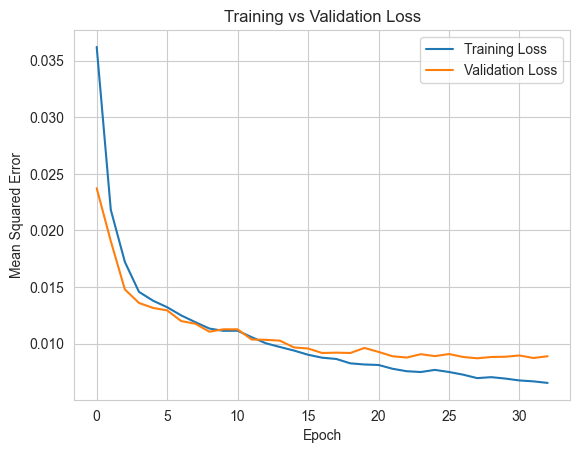

In [14]:
import matplotlib.pyplot as plt

# plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

now we supposedly obtained a 32D meaningful representation of the pictures. we'll use this to train an SVM

In [19]:
encoder = Sequential(autoencoder.layers[:3]) 
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

15/15 [==============================] - 0s 4ms/step


let's see what a random image from the train set looks like originally and what it looks like encoded

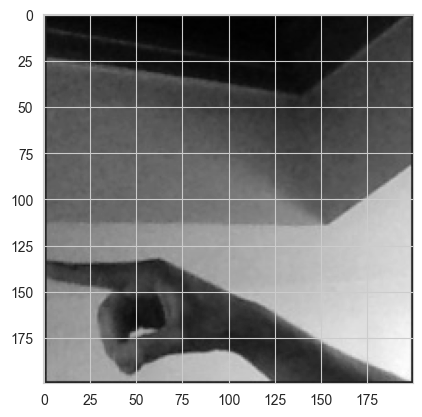

In [20]:
plt.imshow(X_train[5].reshape((200,200)), cmap='gray')

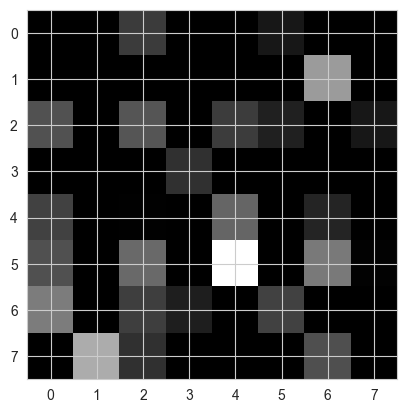

In [21]:
plt.imshow(X_train_encoded[5].reshape((8,8)), cmap='gray')